In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors 
from numpy import linalg as lg
from scipy.optimize import newton #using the optimized scipy library for newton's-raphson method for root-finding
import matplotlib.path as mpath
from scipy.integrate import solve_ivp

#checking the performance of the python code 
import tracemalloc
import pandas as pd
# import dask.dataframe as dd
import time

## System Parameters

In [25]:
M_sun = 1.989E30                        # in kilograms
M_earth = 5.942E24                      # in kilograms
M = M_earth + M_sun                     # in kilograms
R = 1                                   # in AU
pi_1, pi_2 = M_sun / M, M_earth / M

rx_sun, rx_earth = -pi_2*R, pi_1*R      # X coordinate of earth and sun
ry_earth = 0.0                          # Y coordinate of earth

## 1. newton search algorithm


---

#### It returns simultaneous solutions to two equations provided with an appropriate initial guess and increment for the root.

In [26]:
def newton_search_xy(user_func1, user_func2, guess, delta, err):
    x, y = guess[0], guess[1]
    temp1, temp2 = 1.0, 1.0
    while(abs(temp1) + abs(temp2) >= err):
        f = user_func1(x, y)
        g = user_func2(x, y)        
        
        f_x = -pi_1*(-6*pi_2 - 6*x)*(pi_2 + x)/(2*(y**2 + (pi_2 + x)**2)**4) - pi_1/(2*(y**2 + (pi_2 + x)**2)**3) - pi_2*(-pi_1 + x)*(6*pi_1 - 6*x)/(2*(y**2 + (-pi_1 + x)**2)**4) - pi_2/(2*(y**2 + (-pi_1 + x)**2)**3) + 1

        f_y = 3*pi_1*y*(pi_2 + x)/(y**2 + (pi_2 + x)**2)**4 + 3*pi_2*y*(-pi_1 + x)/(y**2 + (-pi_1 + x)**2)**4
        
        g_x = -pi_1*y*(-6*pi_2 - 6*x)/(2*(y**2 + (pi_2 + x)**2)**4) - pi_2*y*(6*pi_1 - 6*x)/(2*(y**2 + (-pi_1 + x)**2)**4) 

        g_y = 3*pi_1*y**2/(y**2 + (pi_2 + x)**2)**4 - pi_1/(2*(y**2 + (pi_2 + x)**2)**3) + 3*pi_2*y**2/(y**2 + (-pi_1 + x)**2)**4 - pi_2/(2*(y**2 + (-pi_1 + x)**2)**3) + 1

        func_arr = np.array([[-f], [-g]])
        Jacob = np.array([[f_x, f_y], [g_x, g_y]])

        delta_arr = np.matmul(lg.inv(Jacob), func_arr)
        x = x + delta_arr[0, 0]
        y = y + delta_arr[1, 0]
        temp1, temp2 = f, g
    return x, y

## 2. return acceleration along x component

---

### It returns scalar x component of acceleration (gravitational and centripetal).

In [27]:
def ret_accelx(x, y):
    global pi_1, pi_2
    sun_term = pi_1 / np.abs((x + pi_2)** 2 + y** 2)**3
    earth_term = pi_2 / np.abs((x - pi_1)** 2 + y** 2)**3
    return x - sun_term*(x + pi_2) - earth_term*(x - pi_1)

def ret_accely(x, y):  
    global pi_1, pi_2
    sun_term = pi_1 / np.abs((x + pi_2)** 2 + y** 2)**3
    earth_term = pi_2 / np.abs((x - pi_1)** 2 + y** 2)**3
    return y - sun_term*y - earth_term*y

In [28]:
def tracing_start(): 
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("Peak Size in MB - ", peak)

### Part 1: 

---
### Analytical results for the acceleration components using non-dimensional units


Let's define a coordinate system with the origin at the center of mass of the Earth-Sun system and place the Sun along the -x axis at x = −R⊙ and the Earth along the + x axis at x = Re.
The center of mass of the system is given as  

 $$COM= \frac{-m_{s} R⊙ + M_{e} R_{e}}{M_{s}}$$ 

Now, According to Newton's Law of Gravitation, Acceleration due to Sun is given as:
$as=- \frac{G M_{s}}{r_{1}^3} \vec{r_{1}}$

$r_{1}= \sqrt{(x+R⊙)^2+ y^2}$

Now in X direction we have acceleration due to Sun as
$as_{x} = -\frac{G M_{s}}{(x+R⊙)^2 + y^2} cosθ_{1}$

Where $cosθ_{1} = \frac{(x+R⊙)}{\sqrt{(x+R⊙)^2 + y^2}}$

Therefore:

$as_{x}=-\frac{G M_{s}(x+R⊙)}{(x+R⊙)^2 + y^2)^{\frac{3}{2}}}$ 





In Y direction,
$$as_{y} = -\frac{G M_{s}}{(x+R⊙)^2 + y^2} sinθ_{1}$$

$$sinθ_{1}= \frac{y}{\sqrt{(x+R⊙)^2 + y^2}}$$

Therefor:

$as_{y}=-\frac{G M_{s}y}{((x+R⊙)^2 + y^2)^{\frac{3}{2}}}$






This can be seen from the Fig 1.
Similarly, for the acceleration due to earth we can see from the figure:

$ae =- \frac{GM_{e}}{r_{2}^3}\vec{r_{2}}$

$r_{2}= \sqrt{(x-R_{E})^2+ y^2}$

In X direction: 
$ae_{x} = -\frac{G M_{e}}{(x-R_e)^2 + y^2} cosθ_{2}$

where $cosθ_2 = \frac{(x-R_e)}{\sqrt{(x-R_e)^2 + y^2}}$

Therefore acceleration due to earth in X direction is given as:
$ae_{x} = -\frac{G M_{e}(x-R_e)}{((x-R_e)^2 + y^2)^{\frac{3}{2}}} $

Similarly, in Y direction it is given as:
$ae_y= -\frac{G M_{e}}{(x-R_e)^2 + y^2} sin\theta_2$

Where $sinθ_2 =\frac{y}{\sqrt{(x-R_e)^2 + y^2}} $

Acceleration in Y direction is given as:
$ae_{x} = -\frac{G M_{e}(y)}{((x-R_e)^2 + y^2)^{\frac{3}{2}}}$

The resultant Acceleration in X direction on the Satellite is:
$a_x(x,y)=-\frac{G M_{s}(x+R⊙)}{(x+R⊙)^2 + y^2)^{\frac{3}{2}}} -\frac{G M_{e}(x-R_e)}{((x-R_e)^2 + y^2)^{\frac{3}{2}}}$
---

The resultant Acceleration in Y direction on the Satellite is:
$a_y(x,y)=-\frac{G M_{s}y}{((x+R⊙)^2 + y^2)^{\frac{3}{2}}}-\frac{G M_{e}(y)}{((x-R_e)^2 + y^2)^{\frac{3}{2}}}$
---




Now, As we know at lagrange points, To rotate synchronously with the Earth an object would need to have an acceleration at the Lagrange point [xL,yL] such that                $$\vec{a}(x_L,y_L) = [-ω^2x,-ω^2y]$$


Therefore, the acceleration at the lagrange point would be equal to the resultant acceleration we found earlier.
$$ 0 = -\frac{G M_{s}(x+R⊙)}{(x+R⊙)^2 + y^2)^{\frac{3}{2}}} -\frac{G M_{e}(x-R_e)}{((x-R_e)^2 + y^2)^{\frac{3}{2}}} + ω^2x $$

$$ 0 = -\frac{G M_{s}y}{((x+R⊙)^2 + y^2)^{\frac{3}{2}}}-\frac{G M_{e}(y)}{((x-R_e)^2 + y^2)^{\frac{3}{2}}} + ω^2y$$

## Part 2: 
----

### Numerical results for the acceleration:

In [29]:
#------------------------------- Defining values ------------------------------#
rad_earth = 0.00005              # approximate radius of earth in AU 
rad_skip = rad_earth/10          

dx = rad_earth/1500
dy = rad_earth/1500
N1, N2 = 800, 800                # Steps in x and y values

# Since the values really close to position of earth were generating huge values of  
# acceleration I skipped the x values when its really close to earth (rad_skip) 

x0, xf = rx_earth - (N1*dx), rx_earth + (N1*dx)
x1f, x20 = rx_earth - rad_skip, rx_earth + rad_skip
x1 = np.arange(x0, x1f + dx, dx) 
x2 = np.arange(x20, xf + dx, dx)
x_val = np.hstack((x1, x2))

y0, yf = ry_earth - (N2*dy), ry_earth + (N2*dy) 
y_val = np.arange(y0, yf + dy, dy)

# Initiating x and y acceleration arrays

Nx, Ny = len(x_val), len(y_val)
accel_x = np.zeros((Ny, Nx))
accel_y = np.zeros((Ny, Nx))

In [30]:
# ------Calculation of acceleration components and magnitude of force ---------#
X, Y = np.meshgrid(x_val, y_val)                
accel_x, accel_y = ret_accelx(X, Y), ret_accely(X, Y)             # Acceleration components 
effec_F = np.sqrt(accel_x**2 + accel_y**2)     # Magnitude of acceleration

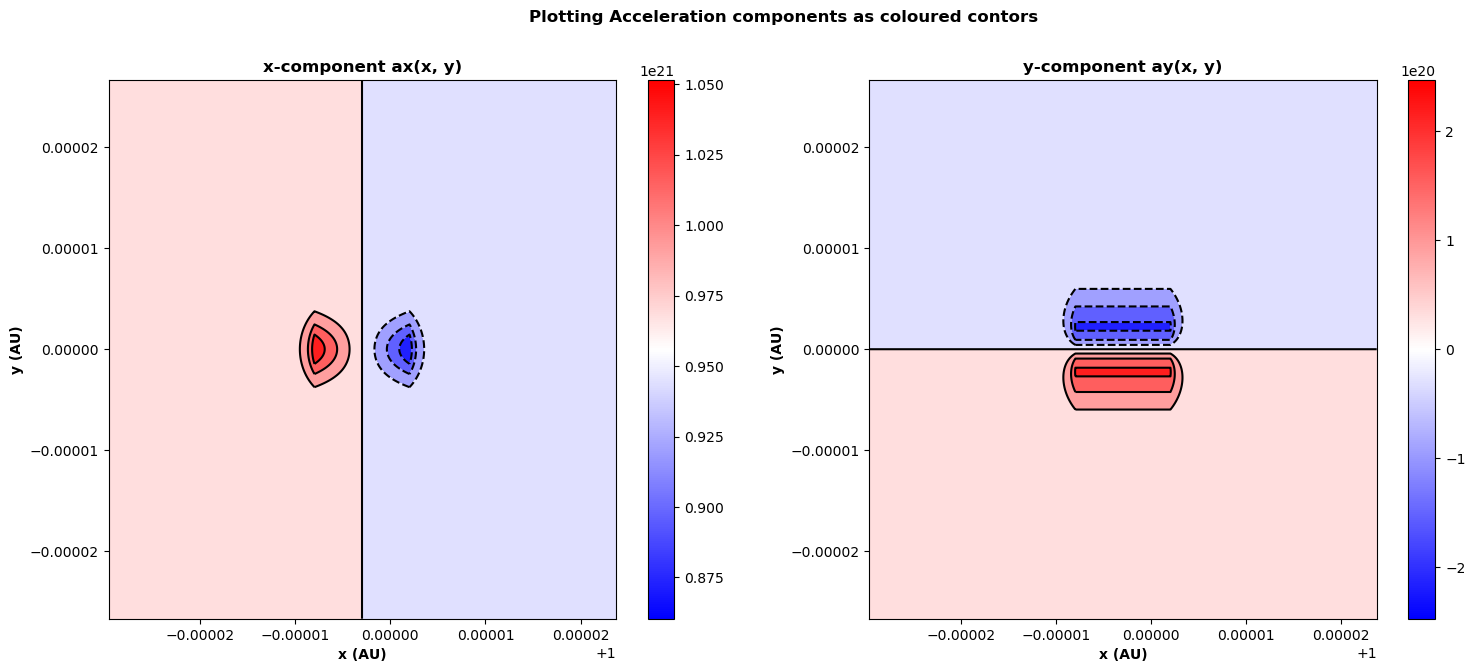

In [35]:
#-----------------------------Plotting----------------------------------------#
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[18, 7])
fig.suptitle(r"Plotting Acceleration components as coloured contors", fontweight = 'bold')

#------------------------------X component------------------------------------#
cs1 = ax1.contourf(X, Y, accel_x, cmap = 'bwr')
ax1.contour(X, Y, accel_x, colors = 'black')
norm = matplotlib.colors.Normalize(vmin = accel_x.max(), vmax = accel_x.max())
sm1 = plt.cm.ScalarMappable(norm=norm, cmap = cs1.cmap)
sm1.set_array([])
fig.colorbar(sm1, ax = ax1)
ax1.set_title(r"x-component ax(x, y)", fontweight = 'bold')
ax1.set_xlabel(r"x (AU)", fontweight = 'bold')
ax1.set_ylabel(r"y (AU)", fontweight = 'bold')

#------------------------------Y component------------------------------------#
cs2 = ax2.contourf(X, Y, accel_y, cmap = 'bwr')
ax2.contour(X, Y, accel_y, colors = 'black')
norm = matplotlib.colors.Normalize(vmin = -accel_y.max(), vmax = accel_y.max())
sm2 = plt.cm.ScalarMappable(norm = norm, cmap = cs2.cmap)
sm2.set_array([])
fig.colorbar(sm2, ax = ax2)
ax2.set_title(r"y-component ay(x, y)", fontweight = 'bold')
ax2.set_xlabel(r"x (AU)", fontweight = 'bold')
ax2.set_ylabel(r"y (AU)", fontweight = 'bold')

plt.show()

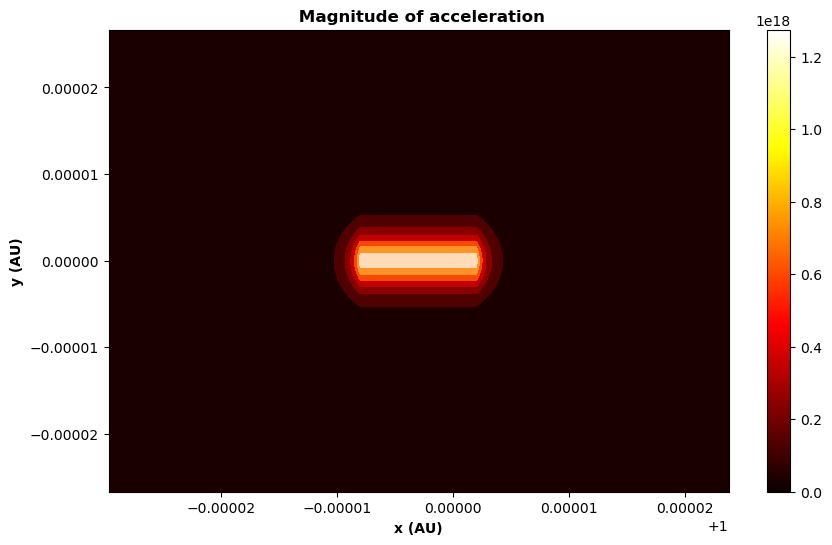

In [36]:
fig, ax = plt.subplots(figsize=[10, 6])

#------------------------------ Magnitude ------------------------------------#
cs = ax.contourf(X, Y, effec_F, cmap = 'gist_heat')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = effec_F.max()/7.5e2)
sm = plt.cm.ScalarMappable(norm = norm, cmap = 'hot')
sm.set_array([])
fig.colorbar(sm, ax=ax)
ax.set_title(r" Magnitude of acceleration", fontweight = 'bold')
ax.set_xlabel(r"x (AU)", fontweight = 'bold')
ax.set_ylabel(r"y (AU)", fontweight = 'bold')

plt.show()

#**Exercise 3 :**

In [ ]:
#------------------------------Collinear Lagrange Points-----------------------#
guess_1 = [1.0, 0.0]
guess_2 = [0.0, 0.0]
guess_3 = [-1.0, 0.0]

def null(a, b):
    return 0

L1 = newton_search_xy(user_func1=ret_accelx, user_func2=null, guess=guess_1, delta=rad_earth/10, err=rad_earth/100)
L2 = newton_search_xy(user_func1=ret_accelx, user_func2=null, guess=guess_2, delta=rad_earth/10, err=rad_earth/100)
L3 = newton_search_xy(user_func1=ret_accelx, user_func2=null, guess=guess_3, delta=rad_earth/10, err=rad_earth/100)
 
print(f'First Lagrange point L1  = {L1} \nSecond Lagrange point L2 = {L2} \nThird Lagrange point L3  = {L3}')

First Lagrange point L1  = (1.0921824465230718, 0.0) 
Second Lagrange point L2 = (0.914394343688492, 0.0) 
Third Lagrange point L3  = (-1.000002056739499, 0.0)


#**Exercise 4 :**

In [ ]:
#------------------------------Equilateral Lagrange Points-----------------------#
guess_1 = [0.5, 1.5]
guess_2 = [0.5, -0.7]

L4 = newton_search_xy(user_func1=ret_accelx, user_func2=ret_accely, guess=guess_1, delta=rad_earth/10, err=rad_earth/100)
L5 = newton_search_xy(user_func1=ret_accelx, user_func2=ret_accely, guess=guess_2, delta=rad_earth/10, err=rad_earth/100)
 
print(f'First Lagrange point L4  = {L4} \nSecond Lagrange point L5 = {L5}')

First Lagrange point L4  = (0.4741501563958146, 0.8804423449184275) 
Second Lagrange point L5 = (0.5217414087085445, -0.8531019007509438)


##**Exercise 5 :**

---



In [ ]:
#define the Earth-Sun system
m_1 = 1.989E30  #mass of sun 
m_2 = 5.942E24    #mass of the earth
pi_2 = m_2/(m_1 + m_2) #set the dimensionless quantity of pi_2

#These give us the coordinates of the orbits of m_2 and m_1 on the unit circle
x_2 = (1 - pi_2) * np.cos(np.linspace(0, np.pi, 100)) 
y_2 = (1 - pi_2) * np.sin(np.linspace(0, np.pi, 100)) 
x_1 = (-pi_2) * np.cos(np.linspace(0, np.pi, 100))
y_1 = (-pi_2) * np.sin(np.linspace(0, np.pi, 100))

#defining the orbital plane as a unit circle
circle = mpath.Path.unit_circle()
wedge_1 = mpath.Path.wedge(90, 180) 
wedge_2 = mpath.Path.wedge(270, 0)

verts = np.concatenate([circle.vertices, wedge_1.vertices[::-1, ...], wedge_2.vertices[::-1, ...]]) #vertices of the wedges marking the end of the path
codes = np.concatenate([circle.codes, wedge_1.codes, wedge_2.codes]) #defining the array for the path along the 2 wedges
center_of_mass = mpath.Path(verts, codes) #seaching the path for the centre of mass

#define a function for the solution of the x co-ordinate of the colinear lagrange points in the dimensionless equation of motion.
def f_colinear(x, pi_2):
    first_term = x
    second_term = (1 - pi_2) / np.abs(x + pi_2)**3 * (x + pi_2)
    third_term = pi_2 / np.abs(x - 1 + pi_2)**3 * (x - 1 + pi_2)
    return first_term - second_term - third_term
#since in the equations of motions for the colinear points y and z = 0, and colinear lagrange points along orbital plane.

In [ ]:
tracing_start()
start = time.time()

#Using the scipy optimize package for Newton-Raphson's method
#where x0 is initial value of the non-dimensional position on the unit circle for non-dimensional parameter for mass pi_2
L_1 = newton(func=f_colinear, x0=0, args=(pi_2,))
L_2 = newton(func=f_colinear, x0=1, args=(pi_2,)) 
L_3 = newton(func=f_colinear, x0=-1, args=(pi_2,))
L_4 = (0.5 - pi_2, np.sqrt(3)/2) #analytically solved L_4 and L_5
L_5 = (0.5 - pi_2, -np.sqrt(3)/2)

print('\n''L_1=', L_1, 'L_2=', L_2, 'L_3=', L_3, 'L_4=', L_4, '\n''L_5=', L_5 )

end = time.time()
print("\ntime elapsed(performance of scipy optimzed library) = {} milli seconds".format((end-start)*1000))
tracing_mem()

nTracing Status :  False
Tracing Status :  True

L_1= 0.9900443513990285 L_2= 1.0100161529913918 L_3= -1.0000012447590947 L_4= (0.49999701257805496, 0.8660254037844386) 
L_5= (0.49999701257805496, -0.8660254037844386)

time elapsed(performance of scipy optimzed library) = 12.71200180053711 milli seconds
Peak Size in MB -  0.012982368469238281


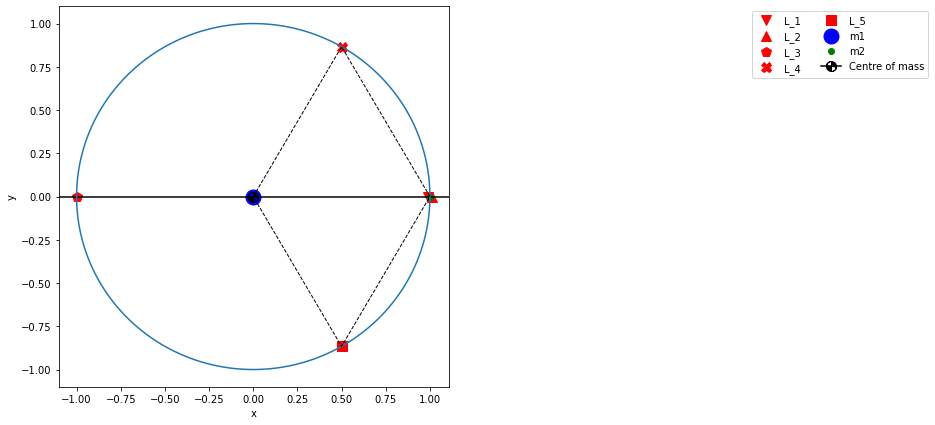

In [ ]:
# Plot the Lagrange Points and masses
plt.subplots(figsize = (7,7))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(L_1, 0, 'rv', markersize = 10, label = "L_1")
plt.plot(L_2, 0, 'r^', markersize = 10, label = "L_2")
plt.plot(L_3, 0, 'rp', markersize = 10, label = "L_3")

plt.plot(0.5 - pi_2, np.sqrt(3)/2, 'rX', markersize = 10, label = "L_4") #analytically solved L_4 
plt.plot(0.5 - pi_2, -np.sqrt(3)/2, 'rs', markersize = 10, label = "L_5") #and L_5

plt.plot(-pi_2, 0, 'bo', label = 'm1', markersize = 15)
plt.plot(1 - pi_2, 0, 'go', label = 'm2')
plt.plot(0, 0, 'k', marker = center_of_mass, markersize=10, label = "Centre of mass")
plt.legend(loc="upper center", bbox_to_anchor=(2, 1), ncol=2)

#plotting for the orbits 
plt.axhline(0, color='k')
plt.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1]))) #plotting the circular orbit between the masses
plt.plot(np.hstack((x_1, x_1[::-1])), np.hstack((y_1, -y_1[::-1])))
plt.plot([-pi_2, 0.5 - pi_2, 1 - pi_2, 0.5 - pi_2, -pi_2], [0, np.sqrt(3)/2, 0, -np.sqrt(3)/2, 0], 'k', ls="--", lw=1)
plt.show()

##**Exercise 6 :**

---



In [ ]:
n = 4 
omega = 2.0E-7
m_1 = 1.989E30   
m_2 = 5.942E24
W = np.zeros((n,n))
def f_L1(J):
    #J = np.zeros((n,n))
    U_xx = 9 * omega**2
    U_xy = 0
    U_yx = 0
    U_yy = -3 * omega**2
    J[2,3] = 2 * omega
    J[3,2] = -2 * omega
    J[0,2] = 1
    J[1,3] = 1
    J[2,0] = -U_xx
    J[2,1] = -U_xy
    J[3,0] = -U_yx
    J[3,1] = -U_yy 
    return J
def f_L2(T):
    #T = np.zeros((n,n))
    U_xx1 = -9 * omega**2
    U_xy1 = 0
    U_yx1 = 0
    U_yy1 = 3 * omega**2
    T[2,3] = 2 * omega
    T[3,2] = -2 * omega
    T[0,2] = 1
    T[1,3] = 1
    T[2,0] = -U_xx1
    T[2,1] = -U_xy1
    T[3,0] = -U_yx1
    T[3,1] = -U_yy1
    return T

def f_L3(K):
    #K = np.zeros((n,n))
    U_xx2 = 3 * omega**2
    U_xy2 = 0
    U_yx2 = 0
    U_yy2 = -(0.875 * (m_2 /m_1)) * omega**2
    K[2,3] = 2 * omega
    K[3,2] = -2 * omega
    K[0,2] = 1
    K[1,3] = 1
    K[2,0] = -U_xx2
    K[2,1] = -U_xy2
    K[3,0] = -U_yx2
    K[3,1] = -U_yy2
    return K

def f_L4(L):
    #L = np.zeros((n,n))
    U_xx3 = -(3 / 4) * omega**2
    U_xy3 = U_yx3 = -(3 * np.sqrt(3) / 4) * (pi_1 - pi_2) * omega**2
    U_yy3 = -(9 / 4) * omega**2
    L[2,3] = 2 * omega
    L[3,2] = -2 * omega
    L[0,2] = 1
    L[1,3] = 1
    L[2,0] = -U_xx3
    L[2,1] = -U_xy3
    L[3,0] = -U_yx3
    L[3,1] = -U_yy3
    return L

def f_L5(M):
    #M = np.zeros((n,n))
    U_xx4 = -(3 / 4) * omega**2
    U_xy4 = U_yx4 = -(3 * np.sqrt(3) / 4) * (pi_1 - pi_2) * omega**2
    U_yy4 = -(9 / 4) * omega**2
    M[2,3] = 2 * omega
    M[3,2] = -2 * omega
    M[0,2] = 1
    M[1,3] = 1
    M[2,0] = -U_xx4
    M[2,1] = -U_xy4
    M[3,0] = -U_yx4
    M[3,1] = -U_yy4
    return M
#Q = f_L1(W)
#A = f_L2(W)
#B = f_L3(W)    
C = f_L4(W)
D = f_L5(W)
#print('\n', Q) 
#print('eigenvalues of L_1=', np.linalg.eigvals(Q))
#print('\n', A)
#print('eigenvalues of L_2=', np.linalg.eigvals(A))
#print('\n', B)
#print('eigenvalues of L_3=', np.linalg.eigvals(B))
print('\n', C)
print('eigenvalues of L_4=', np.linalg.eigvals(C))
print('\n', D)
print('eigenvalues of L_5=', np.linalg.eigvals(D))


 [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.00000000e-14  5.19612138e-14  0.00000000e+00  4.00000000e-07]
 [ 5.19612138e-14  9.00000000e-14 -4.00000000e-07  0.00000000e+00]]
eigenvalues of L_4= [-2.91581166e-23+1.99997983e-07j -2.91581166e-23-1.99997983e-07j
 -4.54277834e-23+8.98119024e-10j -4.54277834e-23-8.98119024e-10j]

 [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.00000000e-14  5.19612138e-14  0.00000000e+00  4.00000000e-07]
 [ 5.19612138e-14  9.00000000e-14 -4.00000000e-07  0.00000000e+00]]
eigenvalues of L_5= [-2.91581166e-23+1.99997983e-07j -2.91581166e-23-1.99997983e-07j
 -4.54277834e-23+8.98119024e-10j -4.54277834e-23-8.98119024e-10j]


Plotting trajectories in order to characterise the stability of the lagrange points that I had found in the previous queston. 

In [ ]:
#intiate the initial values of the tertiary mass
x0 = newton(func=f_colinear, x0=0, args=(pi_2,)) #initial X co-ordinate of tertiary mass kept intitally at L_1 point
y0 = 0 #intial Y co-ordinate of tertiary mass
z0 = 0 #intial Z co-ordinate of tertiary mass
V_x0 = -0.5 #intial Velocity along X co-ordinate of tertiary mass
V_y0 = 0.5  #intial Velocity along Y co-ordinate of tertiary mass
V_z0 = 0

# Then stack everything together into the state vector
r_0 = np.array((x0, y0, z0))
v_0 = np.array((V_x0, V_y0, V_z0))
Sol_0 = np.hstack((r_0, v_0))

#initiate the initial values of the L_2 point
x01 = newton(func=f_colinear, x0=1, args=(pi_2,)) #initial X co-ordinate of tertiary mass kept intitally at L_2 point
y01 = 0 #intial Y co-ordinate of tertiary mass
z01 = 0 #intial Z co-ordinate of tertiary mass
V_x01 = -0.5 #intial Velocity along X co-ordinate of tertiary mass
V_y01 = 0.5  #intial Velocity along Y co-ordinate of tertiary mass
V_z01 = 0

# Then stack everything together into the state vector
r_01 = np.array((x01, y01, z01))
v_01 = np.array((V_x01, V_y01, V_z01))
Sol_01 = np.hstack((r_01, v_01))

#intiate the initial values of the L_3 point
x02 = newton(func=f_colinear, x0=-1, args=(pi_2,))  #intial X co-ordinate of tertiary mass kept intitally at L_3 point
y02 = 0 #intial Y co-ordinate of tertiary mass
z02 = 0 #intial Z co-ordinate of tertiary mass
V_x02 = -0.5 #intial Velocity along X co-ordinate of tertiary mass
V_y02 = 0.5  #intial Velocity along Y co-ordinate of tertiary mass
V_z02 = 0

# Then stack everything together into the state vector
r_02 = np.array((x02, y02, z02))
v_02 = np.array((V_x02, V_y02, V_z02))
Sol_02 = np.hstack((r_02, v_02))

#intiate the initial values of the L_4 point
x03 = 0.5 - pi_2  #intial X co-ordinate of L_4 point
y03 = np.sqrt(3)/2 #intial Y co-ordinate of  L_4
z03 = 0 #intial Z co-ordinate of tertiary mass
V_x03 = -0.5 #intial Velocity along X co-ordinate of tertiary mass
V_y03 = 0.5  #intial Velocity along Y co-ordinate of tertiary mass
V_z03 = 0

# Then stack everything together into the state vector
r_03 = np.array((x03, y03, z03))
v_03 = np.array((V_x03, V_y03, V_z03))
Sol_03 = np.hstack((r_03, v_03))

#intiate the initial values of the L_5 point
x04 = 0.5 - pi_2  #intial X co-ordinate of L_5 point
y04 = -np.sqrt(3)/2 #intial Y co-ordinate of  L_5
z04 = 0 #intial Z co-ordinate of tertiary mass
V_x04 = -0.5 #intial Velocity along X co-ordinate of tertiary mass
V_y04 = 0.5  #intial Velocity along Y co-ordinate of tertiary mass
V_z04 = 0

# Then stack everything together into the state vector
r_04 = np.array((x04, y04, z04))
v_04 = np.array((V_x04, V_y04, V_z04))
Sol_04 = np.hstack((r_04, v_04))

In [ ]:
#define the non-dimensional equations of motion for the L_1 point
def f_nondim_eqs1(t, Sol):
     
    x, y, z = Sol[:3] #vectorise the position co-ordinate into the solution vector
    V_x, V_y, V_z = Sol[3:] #vectorise the velocities along (x, y ,z) into the solution vector
    
    #To simplify, Make the derivative of the solution vector
    dSoldt = np.zeros_like(Sol)
    dSoldt[:3] = Sol[3:]

    sigma = np.sqrt(np.sum(np.square([x + pi_2, y, z]))) #non-dimensional parameters for the tertiary mass
    psi = np.sqrt(np.sum(np.square([x - 1 + pi_2, y, z])))
    dSoldt[3] = 2 * V_y + x - (1 - pi_2) * (x + pi_2) / sigma**3 - pi_2 * (x - 1 + pi_2) / psi**3
    dSoldt[4] = -2 * V_x + y - (1 - pi_2) * y / sigma**3 - pi_2 * y / psi**3
    dSoldt[5] = -(1 - pi_2)/sigma**3 * z - pi_2/psi**3 * z
    return dSoldt

#define the non-dimensional equations of motion for the L_2 point
def f_nondim_eqs2(t, Sol1):
     
    x, y, z = Sol1[:3] #vectorise the position co-ordinate into the solution vector
    V_x, V_y, V_z = Sol1[3:] #vectorise the velocities along (x, y ,z) into the solution vector
    
    #To simplify, Make the derivative of the solution vector
    dSol1dt = np.zeros_like(Sol1)
    dSol1dt[:3] = Sol1[3:]

    sigma1 = np.sqrt(np.sum(np.square([x + pi_2, y, z]))) #non-dimensional parameters for the tertiary mass
    psi1 = np.sqrt(np.sum(np.square([x - 1 + pi_2, y, z])))
    dSol1dt[3] = 2 * V_y + x - (1 - pi_2) * (x + pi_2) / sigma1**3 - pi_2 * (x - 1 + pi_2) / psi1**3
    dSol1dt[4] = -2 * V_x + y - (1 - pi_2) * y / sigma1**3 - pi_2 * y / psi1**3
    dSol1dt[5] = -(1 - pi_2)/sigma1**3 * z - pi_2/psi1**3 * z
    return dSol1dt

#define the non-dimensional equations of motion for the L_3 point
def f_nondim_eqs3(t, Sol2):
     
    x, y, z = Sol2[:3] #vectorise the position co-ordinate into the solution vector
    V_x, V_y, V_z = Sol2[3:] #vectorise the velocities along (x, y ,z) into the solution vector
    
    #To simplify, Make the derivative of the solution vector
    dSol2dt = np.zeros_like(Sol2)
    dSol2dt[:3] = Sol2[3:]

    sigma2 = np.sqrt(np.sum(np.square([x + pi_2, y, z]))) #non-dimensional parameters for the tertiary mass
    psi2 = np.sqrt(np.sum(np.square([x - 1 + pi_2, y, z])))
    dSol2dt[3] = 2 * V_y + x - (1 - pi_2) * (x + pi_2) / sigma2**3 - pi_2 * (x - 1 + pi_2) / psi2**3
    dSol2dt[4] = -2 * V_x + y - (1 - pi_2) * y / sigma2**3 - pi_2 * y / psi2**3
    dSol2dt[5] = -(1 - pi_2)/sigma2**3 * z - pi_2/psi2**3 * z
    return dSol2dt

#define the non-dimensional equations of motion for the L_4 point
def f_nondim_eqs4(t, Sol3):
     
    x, y, z = Sol3[:3] #vectorise the position co-ordinate into the solution vector
    V_x, V_y, V_z = Sol3[3:] #vectorise the velocities along (x, y ,z) into the solution vector
    
    #To simplify, Make the derivative of the solution vector
    dSol3dt = np.zeros_like(Sol3)
    dSol3dt[:3] = Sol3[3:]

    sigma3 = np.sqrt(np.sum(np.square([x + pi_2, y, z]))) #non-dimensional parameters for the tertiary mass
    psi3 = np.sqrt(np.sum(np.square([x - 1 + pi_2, y, z])))
    dSol3dt[3] = 2 * V_y + x - (1 - pi_2) * (x + pi_2) / sigma3**3 - pi_2 * (x - 1 + pi_2) / psi3**3
    dSol3dt[4] = -2 * V_x + y - (1 - pi_2) * y / sigma3**3 - pi_2 * y / psi3**3
    dSol3dt[5] = -(1 - pi_2)/sigma3**3 * z - pi_2/psi3**3 * z
    return dSol3dt

#define the non-dimensional equations of motion for the L_5 point
def f_nondim_eqs5(t, Sol4):
     
    x, y, z = Sol4[:3] #vectorise the position co-ordinate into the solution vector
    V_x, V_y, V_z = Sol4[3:] #vectorise the velocities along (x, y ,z) into the solution vector
    
    #To simplify, Make the derivative of the solution vector
    dSol4dt = np.zeros_like(Sol4)
    dSol4dt[:3] = Sol4[3:]

    sigma4 = np.sqrt(np.sum(np.square([x + pi_2, y, z]))) #non-dimensional parameters for the tertiary mass
    psi4 = np.sqrt(np.sum(np.square([x - 1 + pi_2, y, z])))
    dSol4dt[3] = 2 * V_y + x - (1 - pi_2) * (x + pi_2) / sigma4**3 - pi_2 * (x - 1 + pi_2) / psi4**3
    dSol4dt[4] = -2 * V_x + y - (1 - pi_2) * y / sigma4**3 - pi_2 * y / psi4**3
    dSol4dt[5] = -(1 - pi_2)/sigma4**3 * z - pi_2/psi4**3 * z
    return dSol4dt

#keep same for all the lagrange points
t_initial = 0  #non-dimensional intial time
t_max = 50 #non-dimensional final time
N_points = 10000
t_points = np.linspace(t_initial, t_max, N_points)

#solving the initial value problem for the L_1 point 
solved = solve_ivp(f_nondim_eqs1, [t_initial, t_max], Sol_0, t_eval=t_points)
Sol = solved.y.T #solving for y at time points T
r = Sol[:, :3]  #non-dimensional solution of trajectory
v = Sol[:, 3:]  #non-dimensional Solution of velocity

#solving the initial value problem the for the L_2 point 
solved1 = solve_ivp(f_nondim_eqs2, [t_initial, t_max], Sol_01, t_eval=t_points)
Sol1 = solved1.y.T #solving for y at time points T
r1 = Sol1[:, :3]  #non-dimensional solution of trajectory
v1 = Sol1[:, 3:]  #non-dimensional Solution of velocity

#solving the initial value problem the for the L_3 point 
solved2 = solve_ivp(f_nondim_eqs3, [t_initial, t_max], Sol_02, t_eval=t_points)
Sol2 = solved2.y.T #solving for y at time points T
r2 = Sol2[:, :3]  #non-dimensional solution of trajectory
v2 = Sol2[:, 3:]  #non-dimensional Solution of velocity

#solving the initial value problem the for the L_4 point 
solved3 = solve_ivp(f_nondim_eqs4, [t_initial, t_max], Sol_03, t_eval=t_points)
Sol3 = solved3.y.T #solving for y at time points T
r3 = Sol3[:, :3]  #non-dimensional solution of trajectory
v3 = Sol3[:, 3:]  #non-dimensional Solution of velocity

#solving the initial value problem the for the L_5 point 
solved4 = solve_ivp(f_nondim_eqs5, [t_initial, t_max], Sol_04, t_eval=t_points)
Sol4 = solved4.y.T #solving for y at time points T
r4 = Sol4[:, :3]  #non-dimensional solution of trajectory
v4 = Sol4[:, 3:]  #non-dimensional Solution of velocity

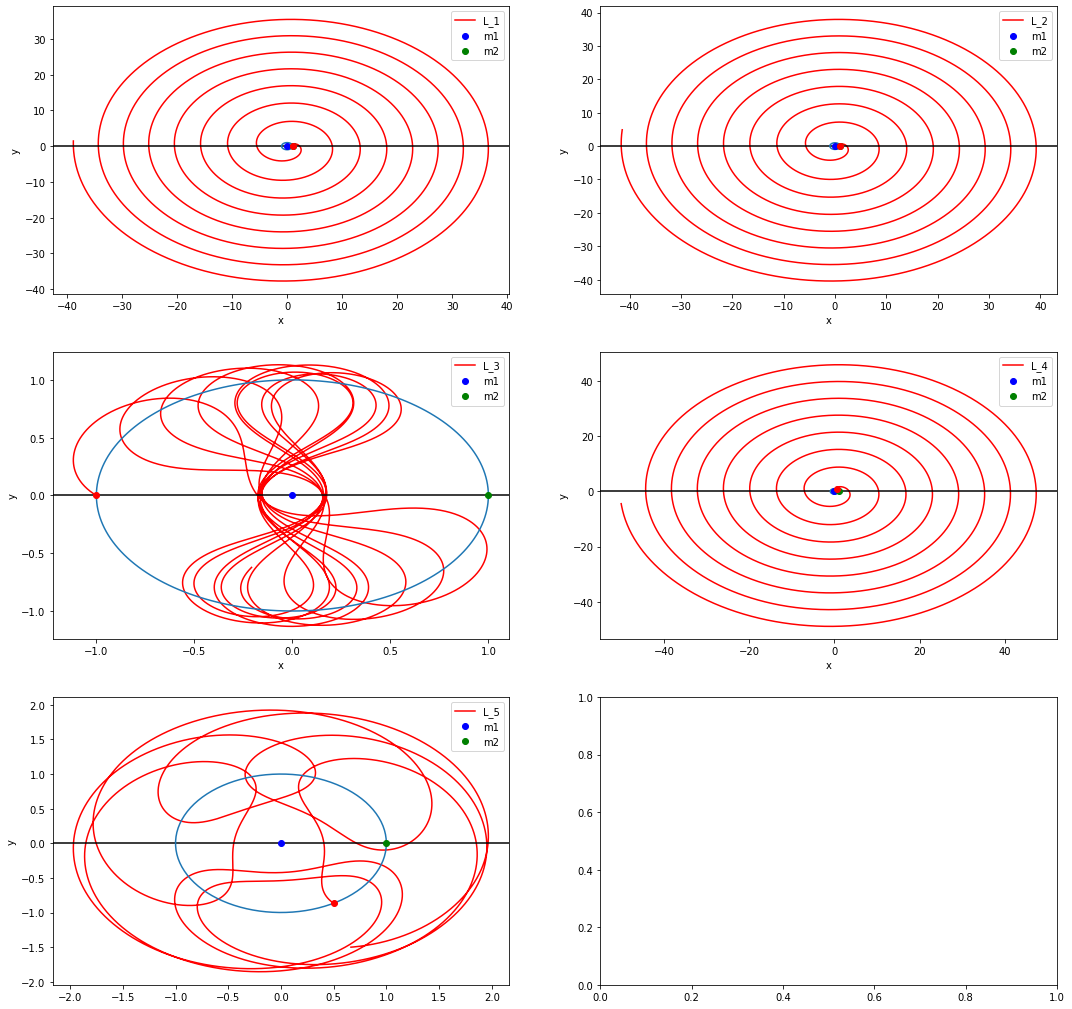

In [107]:
x_2 = (1 - pi_2) * np.cos(np.linspace(0, np.pi, 100)) #X- position of on the earth
y_2 = (1 - pi_2) * np.sin(np.linspace(0, np.pi, 100)) #Y- position of on the earth

#Plotting the trajectory for the L_1 point
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=[18, 18])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.plot(r[:, 0], r[:, 1], 'r', label = 'L_1')
ax1.axhline(0, color = 'k')
ax1.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1]))) #orbit of earth-sun system
ax1.plot(-pi_2, 0, 'bo', label = 'm1')
ax1.plot(1 - pi_2, 0, 'go', label = 'm2')
ax1.plot(x0, y0, 'ro')
ax1.legend()

#Plotting the trajectory for the L_2 point
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.plot(r1[:, 0], r1[:, 1], 'r', label = 'L_2')
ax2.axhline(0, color = 'k')
ax2.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1]))) #orbit of earth-sun system
ax2.plot(-pi_2, 0, 'bo', label = 'm1')
ax2.plot(1 - pi_2, 0, 'go', label = 'm2')
ax2.plot(x01, y01, 'ro')
ax2.legend()

#Plotting the trajectory for the L_3 point

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.plot(r2[:, 0], r2[:, 1], 'r', label = 'L_3')
ax3.axhline(0, color = 'k')
ax3.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1]))) #orbit of earth-sun system
ax3.plot(-pi_2, 0, 'bo', label = 'm1')
ax3.plot(1 - pi_2, 0, 'go', label = 'm2')
ax3.plot(x02, y02, 'ro')
ax3.legend()

#Plotting the trajectory for the L_4 point
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.plot(r3[:, 0], r3[:, 1], 'r', label = 'L_4')
ax4.axhline(0, color = 'k')
ax4.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1]))) #orbit of earth-sun system
ax4.plot(-pi_2, 0, 'bo', label = 'm1')
ax4.plot(1 - pi_2, 0, 'go', label = 'm2')
ax4.plot(x03, y03, 'ro')
ax4.legend()

#Plotting the trajectory for the L_5 point

ax5.set_label('x')
ax5.set_ylabel('y')
ax5.plot(r4[:, 0], r4[:, 1], 'r', label = 'L_5')
ax5.axhline(0, color = 'k')
ax5.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1]))) #orbit of earth-sun system
ax5.plot(-pi_2, 0, 'bo', label = 'm1')
ax5.plot(1 - pi_2, 0, 'go', label = 'm2')
ax5.plot(x04, y04, 'ro')
ax5.legend()
plt.show()

Comments :

---

Since there exist a real positive eigenvalues, L1 and L2 are both dynamically
unstable. Thus small deviations from the equilibrium will grow exponentially
with an e-folding time of tau which is the inverse of the real eigenvalue.

---



Since the Earth has a mass far smaller than that of the Sun, the eigenvalues are small numbers, evaluating the evolution matrix for L3 yields one real and positive eigenvalue and one real and negative eigenvalue, indicating a saddle point. 
Thus is, dynamically unstable. However, since the eigenvalue is much smaller in magnitude than those for L1 and
L2, the instability is less dramatic. An object displaced slightly from L3 will drift away from equilibrium
much more slowly than it would if displaced the same amount from L1 or L2, as I have plotted the trajectories as it confirms this prediction.


---

Lastly, as the mass of the Sun is much greater than the mass of the Earth, the pi_1 is much larger than pi_2, which non-dimensionalize the masses, and with that there will be imaginary eigenvalues to the L4 and L5 points that I have computed, hence out of these I have seen that L5 is more stable than L4 where the trajectories do show that. and so, However if you have a body at L3 it will need far less
adjustment compared to L1 or L2 to maintain a steady orbit. The reason being is that the L3 point is not
influenced by the gravitational potential of the Earth as much as L1 or L2.